In [ ]:
import numpy as np
import torch
from cnn2 import *
from torchvision import datasets, transforms

In [10]:

batch_size = 256
conv1 = Conv2D([batch_size, 28, 28, 1], 12, 5, 1)
relu1 = Relu(conv1.output_shape)
pool1 = MaxPooling(relu1.output_shape)
conv2 = Conv2D(pool1.output_shape, 24, 3, 1)
relu2 = Relu(conv2.output_shape)
pool2 = MaxPooling(relu2.output_shape)
fc = FullyConnect(pool2.output_shape, 10)
sf = Softmax(fc.output_shape)

train_loader = torch.utils.data.DataLoader(datasets.MNIST(
    'data',
    train=True,
    download=False,
    transform=transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307, ), (0.3081, ))])),
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(datasets.MNIST(
    'data',
    train=False,
    transform=transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307, ), (0.3081, ))])),
                                          batch_size=batch_size,
                                          shuffle=True)


def forward(data, target):
    conv1_out = relu1.forward(conv1.forward(data))
    pool1_out = pool1.forward(conv1_out)
    conv2_out = relu2.forward(conv2.forward(pool1_out))
    pool2_out = pool2.forward(conv2_out)
    fc_out = fc.forward(pool2_out)
    loss = sf.cal_loss(fc_out, np.array(target))
    return loss


def train(train_loader, epoch, learning_rate, hparameters):
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        # 提前终止 总共938个batch
        if batch_idx * len(data) >= 5000:
            break
        data = data.permute(0, 2, 3, 1).numpy()
        target = target.numpy()
        loss = forward(data, target)
        # backward
        sf.backward()
        conv1.gradient(
            relu1.gradient(
                pool1.gradient(
                    conv2.gradient(
                        relu2.gradient(pool2.gradient(fc.gradient(sf.eta)))))))
        # update parameters
        fc.backward(learning_rate, hparameters)
        conv2.backward(learning_rate, hparameters)
        conv1.backward(learning_rate, hparameters)

        if (batch_idx + 1) % 2 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss))
        losses.append(loss)
    return losses

def test(test_loader, epoch):
    test_loss = 0
    test_acc = 0
    count = 0
    num_loop = 0
    for data, target in test_loader:
        num_loop += 1
        data = data.permute(0, 2, 3, 1).numpy()
        target = target.numpy()
        test_loss += forward(data, target)

        for j in range(data.shape[0]):
            if np.argmax(sf.softmax[j]) == target[j]:
                test_acc += 1
        count += data.shape[0]
        if count > 500:
            break
    print("epoch:%5d,test_acc:%.4f avg_loss:%.4f" %
          (epoch, test_acc / float(count), test_loss / float(num_loop)))

In [11]:
losses = []
for epoch in range(20):
    test(test_loader, epoch)
    losses.extend(train(train_loader, epoch, 0.0001, 40))
    

epoch:    0,test_acc:0.1016 avg_loss:2.6009
Train Epoch: 0 [256/60000 (0%)]	Loss: 5.899971
Train Epoch: 0 [768/60000 (1%)]	Loss: 3.772086
Train Epoch: 0 [1280/60000 (2%)]	Loss: 2.106934
Train Epoch: 0 [1792/60000 (3%)]	Loss: 1.650226
Train Epoch: 0 [2304/60000 (4%)]	Loss: 1.406861
Train Epoch: 0 [2816/60000 (5%)]	Loss: 1.119021
Train Epoch: 0 [3328/60000 (6%)]	Loss: 0.936522
Train Epoch: 0 [3840/60000 (6%)]	Loss: 0.786118
Train Epoch: 0 [4352/60000 (7%)]	Loss: 0.711169
Train Epoch: 0 [4864/60000 (8%)]	Loss: 0.597128
epoch:    1,test_acc:0.8867 avg_loss:0.6095
Train Epoch: 1 [256/60000 (0%)]	Loss: 0.596683
Train Epoch: 1 [768/60000 (1%)]	Loss: 0.561152
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.548467
Train Epoch: 1 [1792/60000 (3%)]	Loss: 0.466765
Train Epoch: 1 [2304/60000 (4%)]	Loss: 0.482349
Train Epoch: 1 [2816/60000 (5%)]	Loss: 0.431259
Train Epoch: 1 [3328/60000 (6%)]	Loss: 0.502710
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.446549
Train Epoch: 1 [4352/60000 (7%)]	Loss: 0.485175
Trai

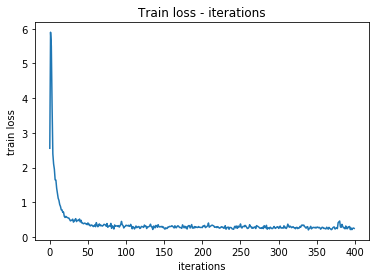

In [14]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel("iterations")
plt.ylabel("train loss")
plt.title("Train loss - iterations")
plt.show()

In [15]:
test(test_loader, epoch)

epoch:   19,test_acc:0.9590 avg_loss:0.2165
